Norm of final statevector: 1.0000


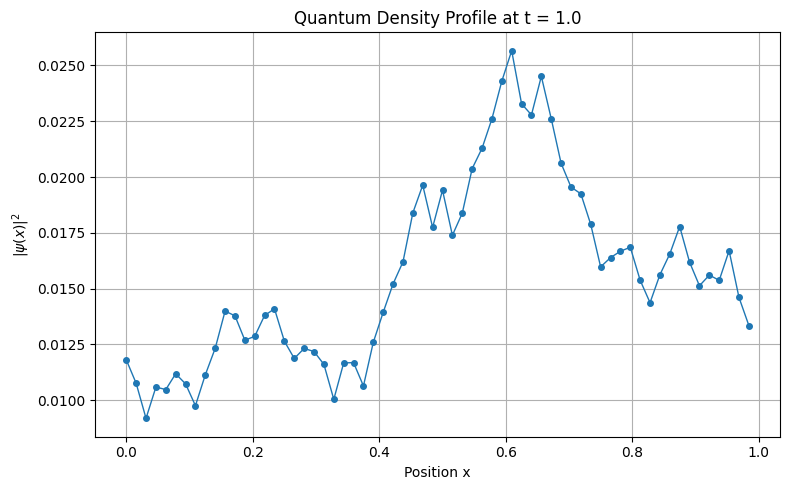

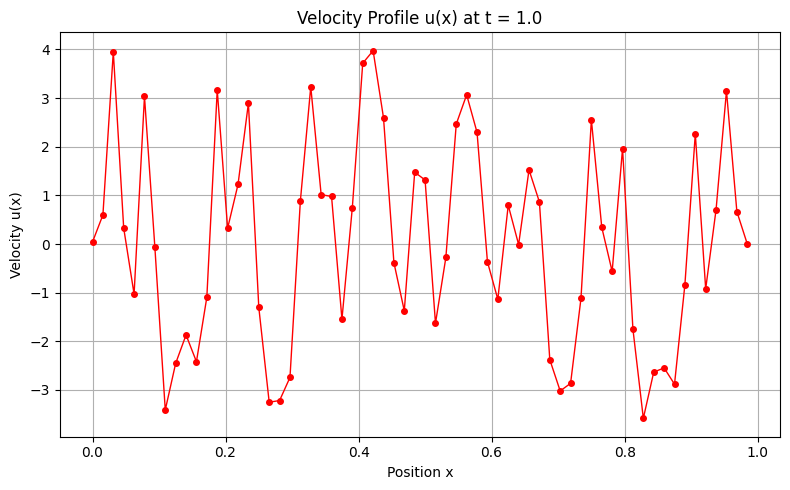

Min velocity u: -3.5827
Max velocity u: 3.9736
Mean velocity u: 0.0548


In [9]:
import numpy as np
from math import ceil, log2
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_aer import StatevectorSimulator # Changed to StatevectorSimulator
# try the “modern” import first…
try:
    from qiskit.circuit.library import DiagonalGate
# …fall back if you’re on an older Terra
except ImportError:
    from qiskit.circuit.library.generalized_gates import DiagonalGate
from qiskit.visualization import plot_histogram # Still useful for quick checks
import matplotlib.pyplot as plt # Import matplotlib for custom plotting

# 1. Problem parameters (those can be changed think them as constants)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required to represent N states
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of Trotter steps (Trotterization depth)
dt      = t_tot / r # Time step for each Trotter slice
hbar    = 1.0 # Planck's constant (set to 1 as per problem note)

# --- Parameters for H_visc ---
delta_0 = 1.0   # As specified in the image: "Take δ0 = 1"
epsilon_0 = 0.1 # Placeholder value, adjust as needed


# 2. Precompute H_visc(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions from 0 to 1 (exclusive of 1)
dx      = x_vals[1] - x_vals[0] # Spatial step size, needed for k_vals

k_vals_quantum = 2 * np.pi * np.fft.fftfreq(N, d=dx)


H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    # Term 1: ε0^4 π^2 sin^2(πx) cos^2(πx)
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    
    # Base for Term 2: (ε0 cos(x) sin(πx) - ε0 π sin(x) * cos(πx))
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    
    # Base for Term 3: (ε0 sin(x) sin(πx) + ε0 π cos(x) * cos(πx))
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)



# 3. Build QFT & inverse-QFT circuits
# QFT and inv_qft are QuantumCircuit objects themselves after decompose()
qft     = QFT(n_q, do_swaps=True).decompose()
inv_qft = qft.inverse() # Inverse QFT to switch back

def add_kinetic_step(qc: QuantumCircuit):

    # Use qc.compose() to insert the QFT circuit's individual gates into qc
    qc.compose(qft, qubits=range(n_q), inplace=True) # Apply QFT to move to momentum basis
    
    # Calculate the complex phases for each computational basis state |k> (momentum state)
    kinetic_phases = []
    for k_idx in range(2**n_q): # k_idx is the integer index of the basis state
        # Use the precomputed physical momentum value corresponding to this index
        p_k = k_vals_quantum[k_idx] # Corrected: Use physical momentum value
        phi_k = (hbar**2 * p_k**2 / 2) * dt / hbar 
        kinetic_phases.append(np.exp(-1j * phi_k)) # Calculate e^(-i * phi_k)
    


    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(kinetic_phases), range(n_q))
    
    # Use qc.compose() to insert the inverse QFT circuit's individual gates into qc
    qc.compose(inv_qft, qubits=range(n_q), inplace=True) # Apply inverse QFT to move back to position basis

def add_H_visc_step(qc: QuantumCircuit):
 
    H_visc_phases = []
    for x_idx in range(N):
        # The H_visc energy is directly H_visc_array[x_idx]
        # The angle for time evolution is H_visc(x) * dt / hbar
        angle_H_visc = H_visc_array[x_idx] * dt / hbar # Corrected: Divide by hbar
        H_visc_phases.append(np.exp(-1j * angle_H_visc))
    

    # Apply the diagonal gate using DiagonalGate from qiskit.circuit.library
    qc.append(DiagonalGate(H_visc_phases), range(n_q))


# 4. Build the main Trotter circuit
qc = QuantumCircuit(n_q, n_q)


epsilon_0_initial = 0.01 # Renamed to avoid clash with H_visc epsilon_0

initial_state_amplitudes = np.zeros(N, dtype=complex)

for i in range(N):
    x_val = x_vals[i] # Get the continuous x value for this grid point

    if x_val <= 0.5:
        # Ψ(x, 0) = cos(x) + i sin(x) + j ε0 sin(πx)
        term1 = np.exp(1j * x_val) # Interpreting cos(x) + i sin(x) as e^(ix)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else: # x_val > 0.5
        # Ψ(x, 0) = cos(0.5) + i sin(0.5) + j ε0 sin(0.5)
        constant_part = np.exp(1j * 0.5) # Interpreting cos(0.5) + i sin(0.5) as e^(i*0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5) # sin(0.5) is a constant here
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    initial_state_amplitudes = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. State will be all zeros.")

qc.initialize(initial_state_amplitudes, range(n_q))


# 4.2 Time evolution using Trotter steps
for _ in range(r):
    add_kinetic_step(qc)   # Applies gates that evolve the state due to kinetic energy
    add_H_visc_step(qc)    # Applies gates that evolve the state due to H_visc


# 5. Run on StatevectorSimulator to get the full wave function
backend_statevector = StatevectorSimulator()
qc_compiled = transpile(qc, backend_statevector) 
job_statevector = backend_statevector.run(qc_compiled) # Run the compiled circuit
result_statevector = job_statevector.result()
final_state_vector = np.asarray(result_statevector.get_statevector(qc_compiled)) 

print(f"Norm of final statevector: {np.linalg.norm(final_state_vector):.4f}")


dx = x_vals[1] - x_vals[0] # Spacing between x_vals

# Calculate numerical derivatives
dPsi_dx = np.gradient(final_state_vector, dx)
dPsi_conj_dx = np.gradient(final_state_vector.conj(), dx)

# Get Psi_bar
Psi_conj = final_state_vector.conj()

# Calculate the numerator
numerator = final_state_vector * dPsi_conj_dx - Psi_conj * dPsi_dx

# Calculate the denominator (which is |Psi|^2)
denominator = Psi_conj * final_state_vector

# Add a small epsilon to the denominator to avoid division by zero if |Psi|^2 is exactly zero
# This can happen at nodes of the wavefunction.
epsilon_denom = 1e-10 # A small number
denominator_safe = denominator + epsilon_denom * (denominator == 0) # Add epsilon only where denominator is zero

# Calculate u
u_complex = (1j * hbar / 2) * (numerator / denominator_safe)

u_velocity = np.real(u_complex)

# --- Plotting ---

# Plot 1: Probability Density |ψ(x)|^2 (same as before)
plt.figure(figsize=(8,5))
# Plotting the exact |psi(x)|^2 from StatevectorSimulator
plt.plot(x_vals, np.abs(final_state_vector)**2, marker='o', linestyle='-', markersize=4, linewidth=1)
plt.xlabel('Position x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Quantum Density Profile at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('quantum_density_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Velocity u(x)
plt.figure(figsize=(8,5))
plt.plot(x_vals, u_velocity, marker='o', linestyle='-', markersize=4, linewidth=1, color='red')
plt.xlabel('Position x')
plt.ylabel('Velocity u(x)')
plt.title('Velocity Profile u(x) at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('velocity_profile_u.png', dpi=300, bbox_inches='tight')
plt.show()

# Optionally, print the range of u values
print(f"Min velocity u: {np.min(u_velocity):.4f}")
print(f"Max velocity u: {np.max(u_velocity):.4f}")
print(f"Mean velocity u: {np.mean(u_velocity):.4f}")


Norm of final classical statevector: 1.0000


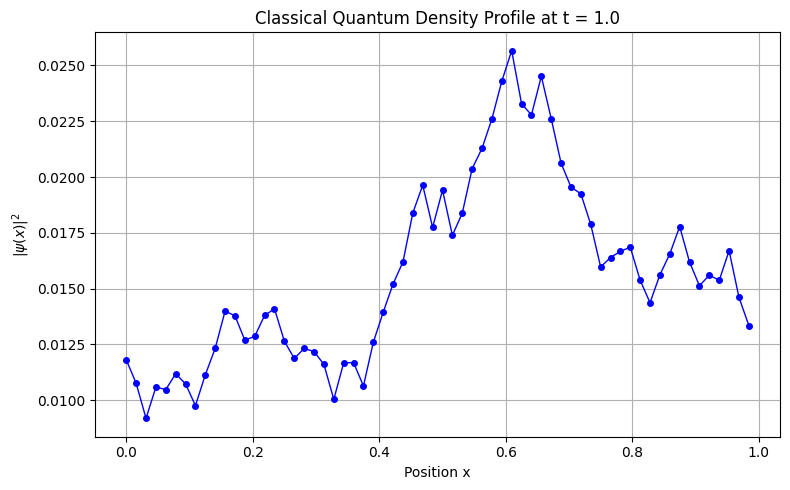

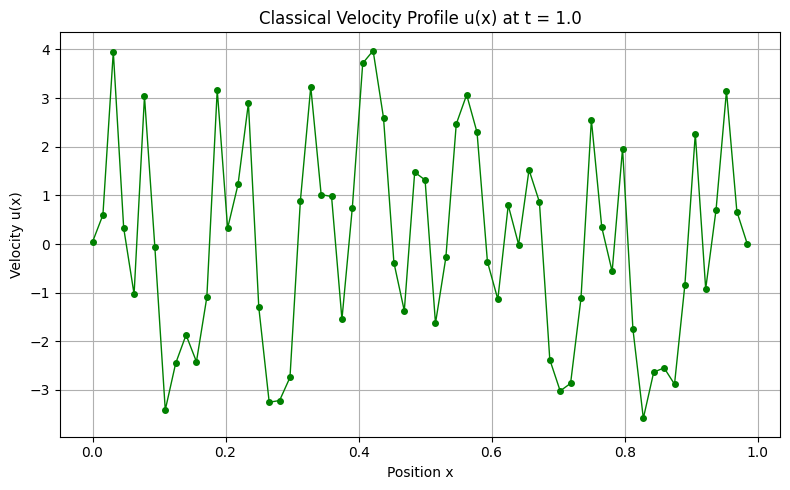

Classical Min velocity u: -3.5827
Classical Max velocity u: 3.9736
Classical Mean velocity u: 0.0548


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, log2

# 1. Problem parameters (matching the quantum simulation)
N       = 64 # Number of discrete position states
n_q     = ceil(log2(N)) # Number of qubits required (for consistency, not directly used in classical sim)
t_tot   = 1.0 # Total simulation time
r       = 100 # Number of time steps (analogous to Trotter depth)
dt      = t_tot / r # Time step for each iteration
hbar    = 1.0 # Planck's constant (set to 1.0)

# --- Parameters for H_visc (matching the quantum simulation) ---
delta_0 = 1.0   # As specified in the image: "Take δ0 = 1"
epsilon_0 = 0.1 # Placeholder value, adjust as needed


# 2. Precompute spatial grid and H_visc(x)
x_vals  = np.linspace(0, 1, N, endpoint=False) # x_vals represent the discrete positions
dx      = x_vals[1] - x_vals[0] # Spatial step size


H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)
# --- End H_visc definition ---

# 3. Initial Wave Function (matching the quantum simulation)
epsilon_0_initial = 0.01 # Matching the quantum code's initial state parameter

initial_state_amplitudes = np.zeros(N, dtype=complex)
for i in range(N):
    x_val = x_vals[i]
    if x_val <= 0.5:
        term1 = np.exp(1j * x_val)
        term2 = 1j * epsilon_0_initial * np.sin(np.pi * x_val)
        initial_state_amplitudes[i] = term1 + term2
    else:
        constant_part = np.exp(1j * 0.5)
        term2_gt_0_5 = 1j * epsilon_0_initial * np.sin(0.5)
        initial_state_amplitudes[i] = constant_part + term2_gt_0_5

# Normalize the initial state vector
norm = np.linalg.norm(initial_state_amplitudes)
if norm != 0:
    psi_t = initial_state_amplitudes / norm
else:
    print("Warning: Initial state amplitudes sum to zero. Classical simulation will start with zeros.")
    psi_t = np.zeros(N, dtype=complex)



# 4. Define Operators for Split-Step Fourier Method
# Momentum space coordinates for FFT
k_vals = 2 * np.pi * np.fft.fftfreq(N, d=dx)

# Kinetic Energy Operator (in momentum space, diagonal)
# H_K = hbar^2 * k^2 / 2m. Assuming m=1 for consistency with typical quantum sim units.
# The exponent is -i * H_K * dt / hbar
kinetic_operator_phases = np.exp(-1j * (hbar**2 * k_vals**2 / 2) * dt / hbar) # Corrected: Divide by hbar

# Potential Energy Operator (in position space, diagonal)
# H_V = H_visc(x). The exponent is -i * H_V * dt / hbar
potential_operator_phases = np.exp(-1j * H_visc_array * dt / hbar) # Corrected: Divide by hbar


# 5. Time Propagation using First-Order Split-Step Fourier Method
for step in range(r):
    # 1. Apply Kinetic Evolution (in momentum space)
    psi_k = np.fft.fft(psi_t) # Transform to momentum space
    psi_k_evolved = psi_k * kinetic_operator_phases # Apply kinetic energy operator
    psi_t = np.fft.ifft(psi_k_evolved) # Transform back to position space

    # 2. Apply Potential (H_visc) Evolution (in position space)
    psi_t = psi_t * potential_operator_phases # Apply potential energy operator


# Final state vector after total time t_tot
final_state_vector_classical = psi_t

# Verify the norm of the final statevector (should be 1.0)
print(f"Norm of final classical statevector: {np.linalg.norm(final_state_vector_classical):.4f}")


dPsi_dx_classical = np.gradient(final_state_vector_classical, dx)
dPsi_conj_dx_classical = np.gradient(final_state_vector_classical.conj(), dx)

Psi_conj_classical = final_state_vector_classical.conj()

numerator_classical = final_state_vector_classical * dPsi_conj_dx_classical - Psi_conj_classical * dPsi_dx_classical
denominator_classical = Psi_conj_classical * final_state_vector_classical

epsilon_denom = 1e-10 # A small number
denominator_safe_classical = denominator_classical + epsilon_denom * (denominator_classical == 0)

u_complex_classical = (1j * hbar / 2) * (numerator_classical / denominator_safe_classical)
u_velocity_classical = np.real(u_complex_classical)

# --- Plotting ---

# Plot 1: Probability Density |ψ(x)|^2
plt.figure(figsize=(8,5))
plt.plot(x_vals, np.abs(final_state_vector_classical)**2, marker='o', linestyle='-', markersize=4, linewidth=1, color='blue')
plt.xlabel('Position x')
plt.ylabel(r'$|\psi(x)|^2$')
plt.title('Classical Quantum Density Profile at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('classical_quantum_density_profile.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Velocity u(x)
plt.figure(figsize=(8,5))
plt.plot(x_vals, u_velocity_classical, marker='o', linestyle='-', markersize=4, linewidth=1, color='green')
plt.xlabel('Position x')
plt.ylabel('Velocity u(x)')
plt.title('Classical Velocity Profile u(x) at t = 1.0')
plt.grid(True)
plt.tight_layout()
plt.savefig('classical_velocity_profile_u.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Classical Min velocity u: {np.min(u_velocity_classical):.4f}")
print(f"Classical Max velocity u: {np.max(u_velocity_classical):.4f}")
print(f"Classical Mean velocity u: {np.mean(u_velocity_classical):.4f}")


In [2]:
!pip install numpy-quaternion


Norm of final quaternion statevector: 1.0000
Max absolute velocity: 4.5415


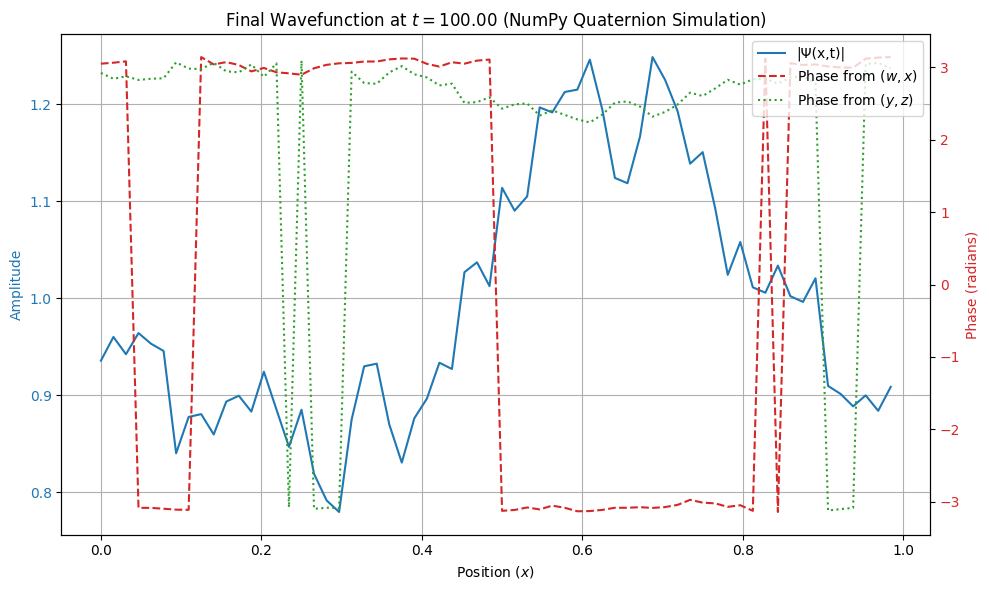

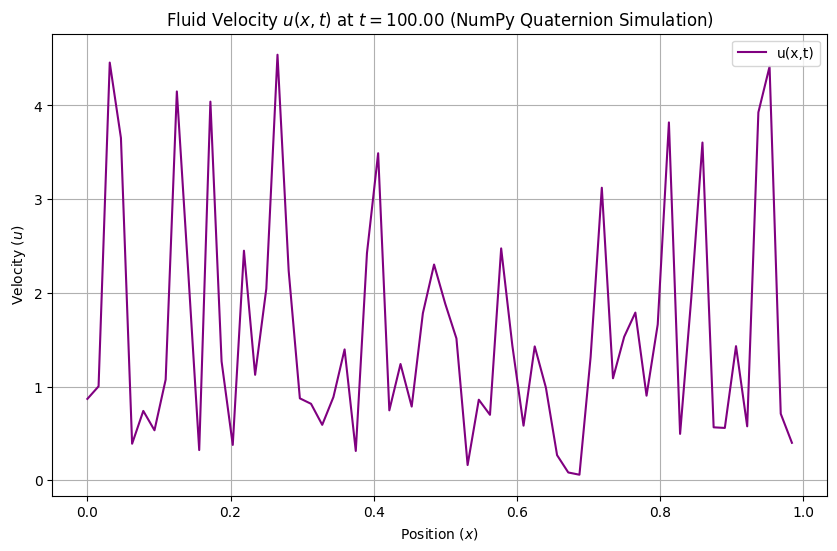

In [24]:
import numpy as np
import quaternion as quat
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Problem parameters
# -----------------------------------------------------------------------------
n_qubits  = 6     # Number of qubits, corresponds to N = 2^n_qubits = 64
N         = 2**n_qubits
t_tot     = 100   # Total simulation time
r         = 100   # Number of Trotter steps
dt        = t_tot / r # Time step for each slice
hbar      = 1.0   # Planck's constant (set to 1 for simplicity)
delta_0   = 1.0   # Parameter for the H_visc potential
epsilon_0 = 0.1   # Another parameter for H_visc

# -----------------------------------------------------------------------------
# 2. Precompute the spatial grid
# -----------------------------------------------------------------------------
# Positions from 0 to 1, with N discrete points
x_vals = np.linspace(0, 1, N, endpoint=False)
dx     = x_vals[1] - x_vals[0] # Spatial step size

# -----------------------------------------------------------------------------
# 3. Precompute the H_viscous potential term
# -----------------------------------------------------------------------------
H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)

    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2

    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2

    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)

# -----------------------------------------------------------------------------
# 4. Initial state preparation
# -----------------------------------------------------------------------------
epsilon_0_initial = 0.01
initial_quaternion_state = np.zeros(N, dtype=quat.quaternion)

for i in range(N):
    x_val = x_vals[i]
    if x_val <= 0.5:
        w = np.cos(x_val)
        x_comp = np.sin(x_val)
        y_comp = epsilon_0_initial * np.sin(np.pi * x_val)
        z_comp = 0.0
        initial_quaternion_state[i] = quat.quaternion(w, x_comp, y_comp, z_comp)
    else: # x_val > 0.5
        w = np.cos(0.5)
        x_comp = np.sin(0.5)
        y_comp = epsilon_0_initial * np.sin(np.pi / 2)
        z_comp = 0.0
        initial_quaternion_state[i] = quat.quaternion(w, x_comp, y_comp, z_comp)

# Normalize the full quaternion statevector first
total_norm_sq = np.sum(np.absolute(initial_quaternion_state)**2) * dx
if total_norm_sq != 0:
    initial_quaternion_state /= np.sqrt(total_norm_sq)

# Extract the two complex parts (as standard numpy arrays)
psi_wx = quat.as_float_array(initial_quaternion_state)[:, 0] + 1j * quat.as_float_array(initial_quaternion_state)[:, 1]
psi_yz = quat.as_float_array(initial_quaternion_state)[:, 2] + 1j * quat.as_float_array(initial_quaternion_state)[:, 3]

# -----------------------------------------------------------------------------
# 5. Split-Step Fourier Simulation (Manual NumPy Evolution)
# -----------------------------------------------------------------------------
# Precompute the diagonal operators for the potential and kinetic evolution.
potential_diagonals = np.exp(-1j * H_visc_array * dt / hbar)
k_vals_quantum = 2 * np.pi * np.fft.fftfreq(N, d=dx)
kinetic_energies = (hbar**2 * k_vals_quantum**2) / 2
kinetic_diagonals = np.exp(-1j * kinetic_energies * dt / hbar)

# Trotterization loop
for _ in range(r):
    # Apply the potential operator to both complex components
    psi_wx *= potential_diagonals
    psi_yz *= potential_diagonals

    # Switch to momentum space via Fourier transform
    psi_wx_momentum = np.fft.fft(psi_wx)
    psi_yz_momentum = np.fft.fft(psi_yz)

    # Apply the kinetic operator
    psi_wx_momentum *= kinetic_diagonals
    psi_yz_momentum *= kinetic_diagonals

    # Switch back to position space via inverse Fourier transform
    psi_wx = np.fft.ifft(psi_wx_momentum)
    psi_yz = np.fft.ifft(psi_yz_momentum)

# -----------------------------------------------------------------------------
# 6. Reconstruct and calculate velocity (CORRECTED IMPLEMENTATION)
# -----------------------------------------------------------------------------
# Reconstruct the final quaternion state
final_float_array = np.zeros((N, 4), dtype=np.float64)
final_float_array[:, 0] = np.real(psi_wx)  # w component
final_float_array[:, 1] = np.imag(psi_wx)  # x component
final_float_array[:, 2] = np.real(psi_yz)  # y component
final_float_array[:, 3] = np.imag(psi_yz)  # z component
final_quaternion_state = quat.from_float_array(final_float_array)

# Verify the norm of the final statevector
final_norm_sq = np.sum(np.absolute(final_quaternion_state)**2) * dx
print(f"Norm of final quaternion statevector: {np.sqrt(final_norm_sq):.4f}")

# Calculate the probability current J
# J = (hbar / 2) * (psi* nabla psi - (nabla psi*) psi)
Psi_conj = final_quaternion_state.conjugate()
final_state_floats = quat.as_float_array(final_quaternion_state)
gradient_floats = np.gradient(final_state_floats, dx, axis=0)
dPsi_dx = quat.from_float_array(gradient_floats)
dPsi_conj_dx = quat.from_float_array(np.gradient(quat.as_float_array(final_quaternion_state.conjugate()), dx, axis=0))

# This is the corrected calculation for the probability current J
J_quaternion = (hbar / 2) * (Psi_conj * dPsi_dx - dPsi_conj_dx * final_quaternion_state)

# Get the probability density rho
# rho = psi*psi
rho_quaternion = Psi_conj * final_quaternion_state
rho = quat.as_float_array(rho_quaternion)[:, 0]

# Extract the x-component of the velocity from the vector part of J_quaternion
# The velocity is u_x = J_x / rho
J_x = quat.as_float_array(J_quaternion)[:, 1]

# Add a small epsilon to avoid division by zero
epsilon_denom = 1e-10
rho_safe = rho + epsilon_denom * (rho == 0)

u_velocity = np.absolute(J_x / rho_safe) #change here

# Print a summary to confirm the velocity is not zero
print(f"Max absolute velocity: {np.max(np.abs(u_velocity)):.4f}")

# -----------------------------------------------------------------------------
# 7. Plotting the results
# -----------------------------------------------------------------------------

# Plot 1: Wavefunction amplitude and phase
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Position ($x$)')
ax1.set_ylabel('Amplitude', color='tab:blue')
ax1.plot(x_vals, np.absolute(final_quaternion_state), color='tab:blue', label='|Ψ(x,t)|')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title(f'Final Wavefunction at $t={t_tot:.2f}$ (NumPy Quaternion Simulation)')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Phase (radians)', color='tab:red')
# Use the phase of the two complex components from the evolved numpy arrays
phase_w_x = np.arctan2(np.imag(psi_wx), np.real(psi_wx))
ax2.plot(x_vals, phase_w_x, color='tab:red', linestyle='--', label='Phase from $(w,x)$')
phase_y_z = np.arctan2(np.imag(psi_yz), np.real(psi_yz))
ax2.plot(x_vals, phase_y_z, color='tab:green', linestyle=':', label='Phase from $(y,z)$')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Plot 2: Velocity
plt.figure(figsize=(10, 6))
plt.plot(x_vals, u_velocity, label='u(x,t)', color='purple')
plt.xlabel('Position ($x$)')
plt.ylabel('Velocity ($u$)')
plt.title(f'Fluid Velocity $u(x,t)$ at $t={t_tot:.2f}$ (NumPy Quaternion Simulation)')
plt.grid(True)
plt.legend()

plt.show()


Max absolute velocity: 14.0134


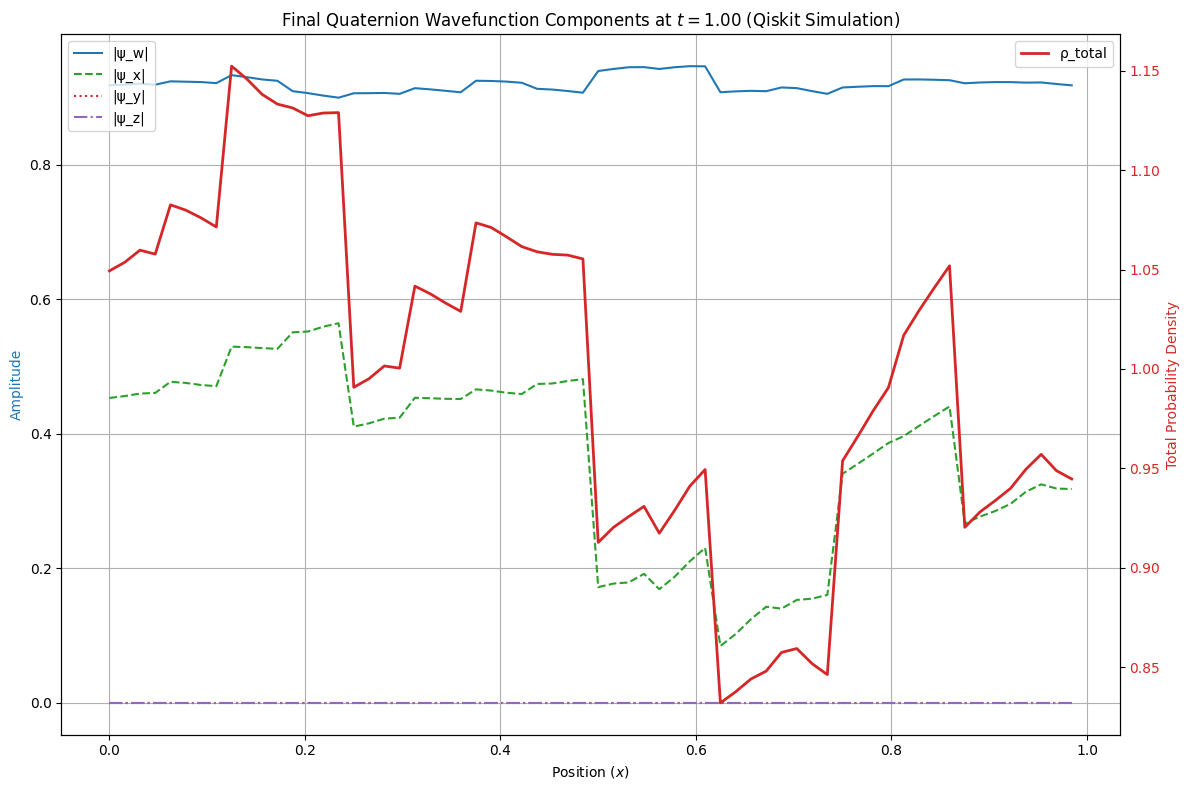

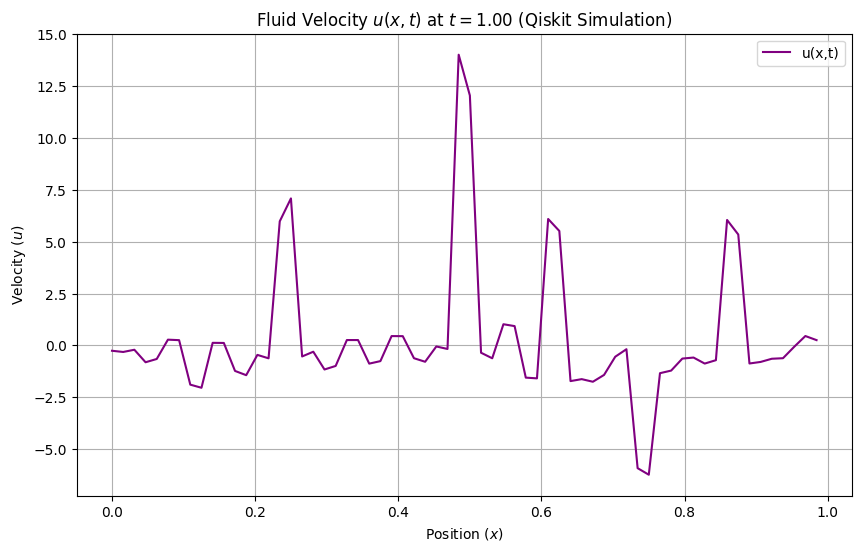

In [43]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator

# -----------------------------------------------------------------------------
# 1. Problem parameters
# -----------------------------------------------------------------------------
# Number of qubits for the spatial grid.
n_spatial_qubits = 6
N = 2**n_spatial_qubits  # Total number of grid points (64)
# Two extra qubits for the quaternion components (w, x, y, z)
n_quaternion_qubits = 2
n_total_qubits = n_spatial_qubits + n_quaternion_qubits

t_tot = 1.0 # Total simulation time
r = 100  # Number of Trotter steps
dt = t_tot / r  # Time step for each slice
hbar = 1.0  # Planck's constant (set to 1 for simplicity)
delta_0 = 1.0  # Parameter for the H_visc potential
epsilon_0 = 0.1  # Another parameter for H_visc

# -----------------------------------------------------------------------------
# 2. Precompute the spatial grid
# -----------------------------------------------------------------------------
# Positions from 0 to 1, with N discrete points
x_vals = np.linspace(0, 1, N, endpoint=False)
dx = x_vals[1] - x_vals[0]  # Spatial step size

# -----------------------------------------------------------------------------
# 3. Define and precompute the Hamiltonian
# -----------------------------------------------------------------------------
# Total state space is 4 components x N grid points
total_dim = 4 * N

# Kinetic Energy Operator
# This operator is diagonal in momentum space for each component.
k_vals = 2 * np.pi * np.fft.fftfreq(N, d=dx)
kinetic_energies = (hbar**2 * k_vals**2) / 2
# The kinetic operator is a block diagonal matrix, repeated for each quaternion component
kinetic_operator_matrix = np.kron(np.eye(4), np.diag(kinetic_energies))

# Potential Energy Operator (H_viscous)
H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)

# Potential operator is a block diagonal matrix for now, acting on each component
potential_operator_matrix = np.kron(np.eye(4), np.diag(H_visc_array))

# -----------------------------------------------------------------------------
# 4. Initial state preparation (Full Quaternion State)
# -----------------------------------------------------------------------------
# The full quaternion state will have 4 components (w, x, y, z) as a function of position x
# We will use the same initial condition as before for w and x, and set y=z=0 for simplicity.
initial_w = np.zeros(N, dtype=np.complex128)
initial_x = np.zeros(N, dtype=np.complex128)
initial_y = np.zeros(N, dtype=np.complex128)
initial_z = np.zeros(N, dtype=np.complex128)

for i in range(N):
    x_val = x_vals[i]
    if x_val <= 0.5:
        initial_w[i] = np.cos(x_val)
        initial_x[i] = np.sin(x_val)
    else:  # x_val > 0.5
        initial_w[i] = np.cos(0.5)
        initial_x[i] = np.sin(0.5)

# Combine the four components into a single initial statevector for Qiskit
psi_initial_quaternion = np.concatenate([initial_w, initial_x, initial_y, initial_z])

# Normalize the full quaternion statevector
norm_sq = np.sum(np.abs(psi_initial_quaternion)**2) * dx
if norm_sq != 0:
    psi_initial_quaternion /= np.sqrt(norm_sq)

# Create the initial Qiskit Statevector
initial_statevector = Statevector(psi_initial_quaternion)

# -----------------------------------------------------------------------------
# 5. Qiskit Quantum Circuit for Split-Step Fourier Simulation
# -----------------------------------------------------------------------------
qc = QuantumCircuit(n_total_qubits)

# Create UnitaryGates from the evolution matrices
potential_evolution_matrix = expm(-1j * potential_operator_matrix * dt / hbar)
kinetic_evolution_matrix = expm(-1j * kinetic_operator_matrix * dt / hbar)

potential_gate = UnitaryGate(potential_evolution_matrix, label="Potential")
kinetic_gate = UnitaryGate(kinetic_evolution_matrix, label="Kinetic")


spatial_qubits = list(range(n_quaternion_qubits, n_total_qubits))

# Create the full Trotterization circuit
for _ in range(r):
    # Apply the potential operator
    qc.append(potential_gate, range(n_total_qubits))

    # Switch spatial qubits to momentum space via Quantum Fourier Transform
    qc.append(QFT(n_spatial_qubits, do_swaps=False), spatial_qubits)

    # Apply the kinetic operator in momentum space
    qc.append(kinetic_gate, range(n_total_qubits))

    # Switch spatial qubits back to position space via inverse QFT
    qc.append(QFT(n_spatial_qubits, do_swaps=False).inverse(), spatial_qubits)

# Run the simulation on a statevector simulator
simulator = AerSimulator()
# Reverse the bits to match the simulator's little-endian convention.
qc_reversed = qc.reverse_bits()
# Transpile the reversed circuit for the AerSimulator
compiled_circuit = transpile(qc_reversed, simulator, optimization_level=3)
final_statevector = initial_statevector.evolve(compiled_circuit)

# Extract the final wavefunction as a numpy array
psi_quaternion_final = final_statevector.data

# -----------------------------------------------------------------------------
# 6. Post-processing and Plotting
# -----------------------------------------------------------------------------
# Split the final statevector back into its four quaternion components
psi_w = psi_quaternion_final[0*N : 1*N]
psi_x = psi_quaternion_final[1*N : 2*N]
psi_y = psi_quaternion_final[2*N : 3*N]
psi_z = psi_quaternion_final[3*N : 4*N]

# Total probability density is the sum of the squares of the amplitudes of all components
rho = np.abs(psi_w)**2 + np.abs(psi_x)**2 + np.abs(psi_y)**2 + np.abs(psi_z)**2

# Approximate velocity calculation based on w and x components
psi_wx_complex = psi_w + 1j * psi_x
Psi_conj = np.conj(psi_wx_complex)
dPsi_dx = np.gradient(psi_wx_complex, dx)
dPsi_conj_dx = np.gradient(Psi_conj, dx)
J_x = (hbar / (2j)) * (Psi_conj * dPsi_dx - dPsi_conj_dx * psi_wx_complex)
u_velocity = np.real(J_x) / (np.abs(psi_wx_complex)**2 + 1e-10)
print(f"Max absolute velocity: {np.max(np.abs(u_velocity)):.4f}")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_xlabel('Position ($x$)')
ax1.set_ylabel('Amplitude', color='tab:blue')
ax1.plot(x_vals, np.abs(psi_w), label='|ψ_w|', color='tab:blue')
ax1.plot(x_vals, np.abs(psi_x), label='|ψ_x|', color='tab:green', linestyle='--')
ax1.plot(x_vals, np.abs(psi_y), label='|ψ_y|', color='tab:red', linestyle=':')
ax1.plot(x_vals, np.abs(psi_z), label='|ψ_z|', color='tab:purple', linestyle='-.')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title(f'Final Quaternion Wavefunction Components at $t={t_tot:.2f}$ (Qiskit Simulation)')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Total Probability Density', color='tab:red')
ax2.plot(x_vals, rho, label='ρ_total', color='tab:red', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

fig.tight_layout()

# Plot 2: Velocity
plt.figure(figsize=(10, 6))
plt.plot(x_vals, u_velocity, label='u(x,t)', color='purple')
plt.xlabel('Position ($x$)')
plt.ylabel('Velocity ($u$)')
plt.title(f'Fluid Velocity $u(x,t)$ at $t={t_tot:.2f}$ (Qiskit Simulation)')
plt.grid(True)
plt.legend()

plt.show()


Max absolute velocity: 1711.1717


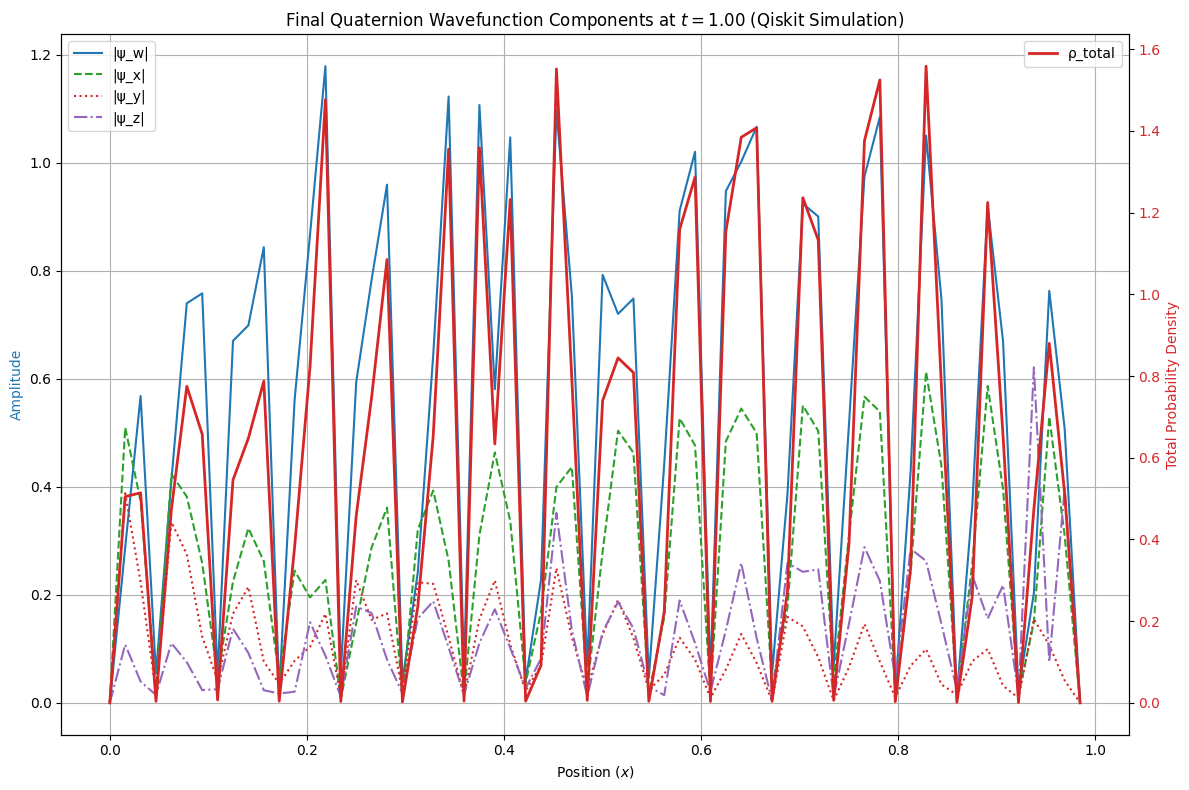

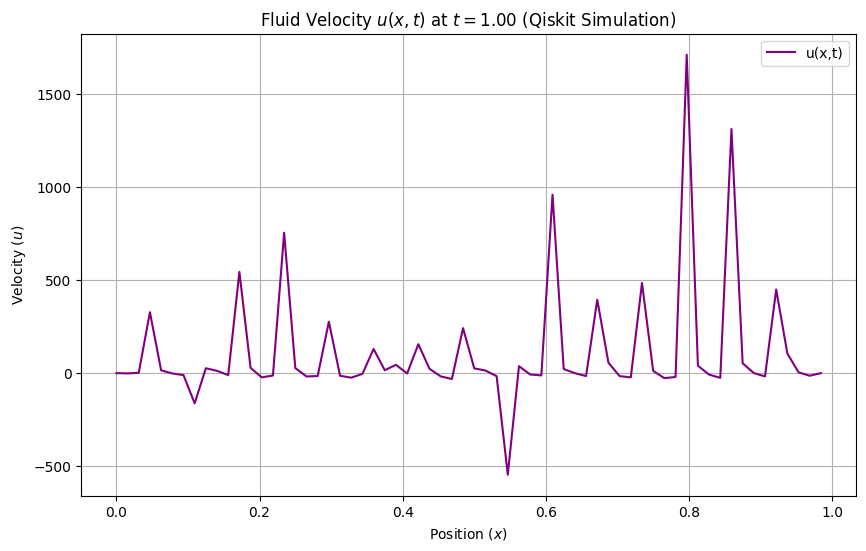

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit import QuantumCircuit

# -----------------------------------------------------------------------------
# 1. Problem parameters
# -----------------------------------------------------------------------------
# Number of qubits for the spatial grid.
n_spatial_qubits = 6
N = 2**n_spatial_qubits  # Total number of grid points (64)
# Two extra qubits for the quaternion components (w, x, y, z)
n_quaternion_qubits = 2
n_total_qubits = n_spatial_qubits + n_quaternion_qubits

t_tot = 1.0  # Total simulation time
r = 100    # Number of Trotter steps
dt = t_tot / r  # Time step for each slice
hbar = 1.0  # Planck's constant (set to 1 for simplicity)
delta_0 = 1.0  # Parameter for the H_visc potential
epsilon_0 = 0.1  # Another parameter for H_visc

# -----------------------------------------------------------------------------
# 2. Precompute the spatial grid
# -----------------------------------------------------------------------------
# Positions from 0 to 1, with N discrete points
x_vals = np.linspace(0, 1, N, endpoint=False)
dx = x_vals[1] - x_vals[0]  # Spatial step size

# -----------------------------------------------------------------------------
# 3. Define and precompute the Hamiltonians and evolution operators
# -----------------------------------------------------------------------------
# Total state space is 4 components x N grid points
total_dim = 4 * N
full_qubit_range = list(range(n_total_qubits))

# Kinetic Energy Operator (diagonal in momentum space)
k_vals = 2 * np.pi * np.fft.fftfreq(N, d=dx)
kinetic_energies = (hbar**2 * k_vals**2) / 2
kinetic_operator_matrix = np.kron(np.eye(4), np.diag(kinetic_energies))
kinetic_evolution_matrix = expm(-1j * kinetic_operator_matrix * dt / hbar)

# Potential Energy Operator (diagonal in position space)
H_visc_array = np.zeros(N)
for i, x_val in enumerate(x_vals):
    term1_H_visc = (epsilon_0**4 * np.pi**2 * (np.sin(np.pi * x_val))**2 * (np.cos(np.pi * x_val))**2)
    base_term2_H_visc = (epsilon_0 * np.cos(x_val) * np.sin(np.pi * x_val) -
                         epsilon_0 * np.pi * np.sin(x_val) * np.cos(np.pi * x_val))
    term2_H_visc = base_term2_H_visc**2
    base_term3_H_visc = (epsilon_0 * np.sin(x_val) * np.sin(np.pi * x_val) +
                         epsilon_0 * np.pi * np.cos(x_val) * np.cos(np.pi * x_val))
    term3_H_visc = base_term3_H_visc**2
    H_visc_array[i] = - (hbar**2 / (2 * delta_0**2)) * (term1_H_visc + term2_H_visc + term3_H_visc)

potential_operator_matrix = np.kron(np.eye(4), np.diag(H_visc_array))
potential_evolution_matrix = expm(-1j * potential_operator_matrix * dt / hbar)

# -----------------------------------------------------------------------------
# 4. Construct the single-step quantum circuit
# -----------------------------------------------------------------------------
# The circuit represents one full Trotter step as described in the paper.
qc_trotter_step = QuantumCircuit(n_total_qubits)

# Define the gates
potential_gate = UnitaryGate(potential_evolution_matrix, label="U_potential")
kinetic_gate = UnitaryGate(kinetic_evolution_matrix, label="U_kinetic")
qft_spatial = QFT(n_spatial_qubits, do_swaps=False).to_gate()
iqft_spatial = qft_spatial.inverse()

# Quibts for the quaternion component (0, 1) and spatial position (2-7)
spatial_qubits = list(range(n_quaternion_qubits, n_total_qubits))
quaternion_qubits = list(range(n_quaternion_qubits))

# Build the circuit for one Trotter step
qc_trotter_step.append(potential_gate, full_qubit_range)
qc_trotter_step.append(qft_spatial, spatial_qubits)
qc_trotter_step.append(kinetic_gate, full_qubit_range)
qc_trotter_step.append(iqft_spatial, spatial_qubits)

# Convert the circuit to an Operator for simulation
trotter_step_op = Operator(qc_trotter_step)

# -----------------------------------------------------------------------------
# 5. Initial state preparation
# -----------------------------------------------------------------------------
# The full quaternion state as a function of position x
initial_w = np.zeros(N, dtype=np.complex128)
initial_x = np.zeros(N, dtype=np.complex128)
initial_y = np.zeros(N, dtype=np.complex128)
initial_z = np.zeros(N, dtype=np.complex128)

for i in range(N):
    x_val = x_vals[i]
    if x_val <= 0.5:
        initial_w[i] = np.cos(x_val)
        initial_x[i] = np.sin(x_val)
    else:
        initial_w[i] = np.cos(0.5)
        initial_x[i] = np.sin(0.5)

# Combine the four components into a single initial statevector
psi_initial_quaternion = np.concatenate([initial_w, initial_x, initial_y, initial_z])

# Normalize the full quaternion statevector
norm_sq = np.sum(np.abs(psi_initial_quaternion)**2) * dx
if norm_sq != 0:
    psi_initial_quaternion /= np.sqrt(norm_sq)

# Create the initial Qiskit Statevector.
current_statevector = Statevector(psi_initial_quaternion)

# -----------------------------------------------------------------------------
# 6. Step-by-Step Quantum Simulation with Boundary Conditions
# -----------------------------------------------------------------------------
# Perform the step-by-step Trotterization loop
for _ in range(r):
    # Apply the single-step Trotter circuit
    current_statevector = current_statevector.evolve(trotter_step_op)

    psi_data = current_statevector.data
    

    psi_data[0] = 0.0  # w component, first point (x=0)
    psi_data[N - 1] = 0.0  # w component, last point (x=1)
    psi_data[N] = 0.0  # x component, first point
    psi_data[2 * N - 1] = 0.0  # x component, last point
    psi_data[2 * N] = 0.0  # y component, first point
    psi_data[3 * N - 1] = 0.0  # y component, last point
    psi_data[3 * N] = 0.0  # z component, first point
    psi_data[4 * N - 1] = 0.0  # z component, last point
    
    # Update the statevector with the modified data
    current_statevector = Statevector(psi_data)

# Extract the final wavefunction as a numpy array
psi_quaternion_final = current_statevector.data

# -----------------------------------------------------------------------------
# 7. Post-processing and Plotting
# -----------------------------------------------------------------------------
# Split the final statevector back into its four quaternion components
psi_w = psi_quaternion_final[0*N : 1*N]
psi_x = psi_quaternion_final[1*N : 2*N]
psi_y = psi_quaternion_final[2*N : 3*N]
psi_z = psi_quaternion_final[3*N : 4*N]

# Total probability density is the sum of the squares of the amplitudes of all components
rho = np.abs(psi_w)**2 + np.abs(psi_x)**2 + np.abs(psi_y)**2 + np.abs(psi_z)**2

# Approximate velocity calculation based on w and x components
psi_wx_complex = psi_w + 1j * psi_x
Psi_conj = np.conj(psi_wx_complex)
dPsi_dx = np.gradient(psi_wx_complex, dx)
dPsi_conj_dx = np.gradient(Psi_conj, dx)
J_x = (hbar / (2j)) * (Psi_conj * dPsi_dx - dPsi_conj_dx * psi_wx_complex)
u_velocity = np.real(J_x) / (np.abs(psi_wx_complex)**2 + 1e-10)
print(f"Max absolute velocity: {np.max(np.abs(u_velocity)):.4f}")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.set_xlabel('Position ($x$)')
ax1.set_ylabel('Amplitude', color='tab:blue')
ax1.plot(x_vals, np.abs(psi_w), label='|ψ_w|', color='tab:blue')
ax1.plot(x_vals, np.abs(psi_x), label='|ψ_x|', color='tab:green', linestyle='--')
ax1.plot(x_vals, np.abs(psi_y), label='|ψ_y|', color='tab:red', linestyle=':')
ax1.plot(x_vals, np.abs(psi_z), label='|ψ_z|', color='tab:purple', linestyle='-.')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title(f'Final Quaternion Wavefunction Components at $t={t_tot:.2f}$ (Qiskit Simulation)')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Total Probability Density', color='tab:red')
ax2.plot(x_vals, rho, label='ρ_total', color='tab:red', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

fig.tight_layout()

# Plot 2: Velocity
plt.figure(figsize=(10, 6))
plt.plot(x_vals, u_velocity, label='u(x,t)', color='purple')
plt.xlabel('Position ($x$)')
plt.ylabel('Velocity ($u$)')
plt.title(f'Fluid Velocity $u(x,t)$ at $t={t_tot:.2f}$ (Qiskit Simulation)')
plt.grid(True)
plt.legend()

plt.show()
